In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount Google drive to access the dataset (Plant Images and Labels)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Labels.csv')

# **Summary**

In [4]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4,750 images in this dataset with the shape (128,128,3)

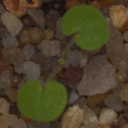

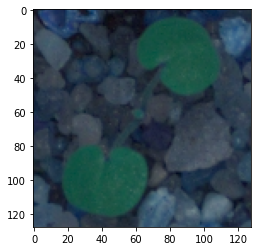

In [5]:
cv2_imshow(images[5]) 
plt.imshow(images[5])

 

*   We can observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.
*   We will convert these BGR images to RGB images so we could interpret them easily.




In [6]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [7]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 5                                                                        # Defining number of rows=5
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(18, 18))                                              # Defining the figure size to 18x18
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

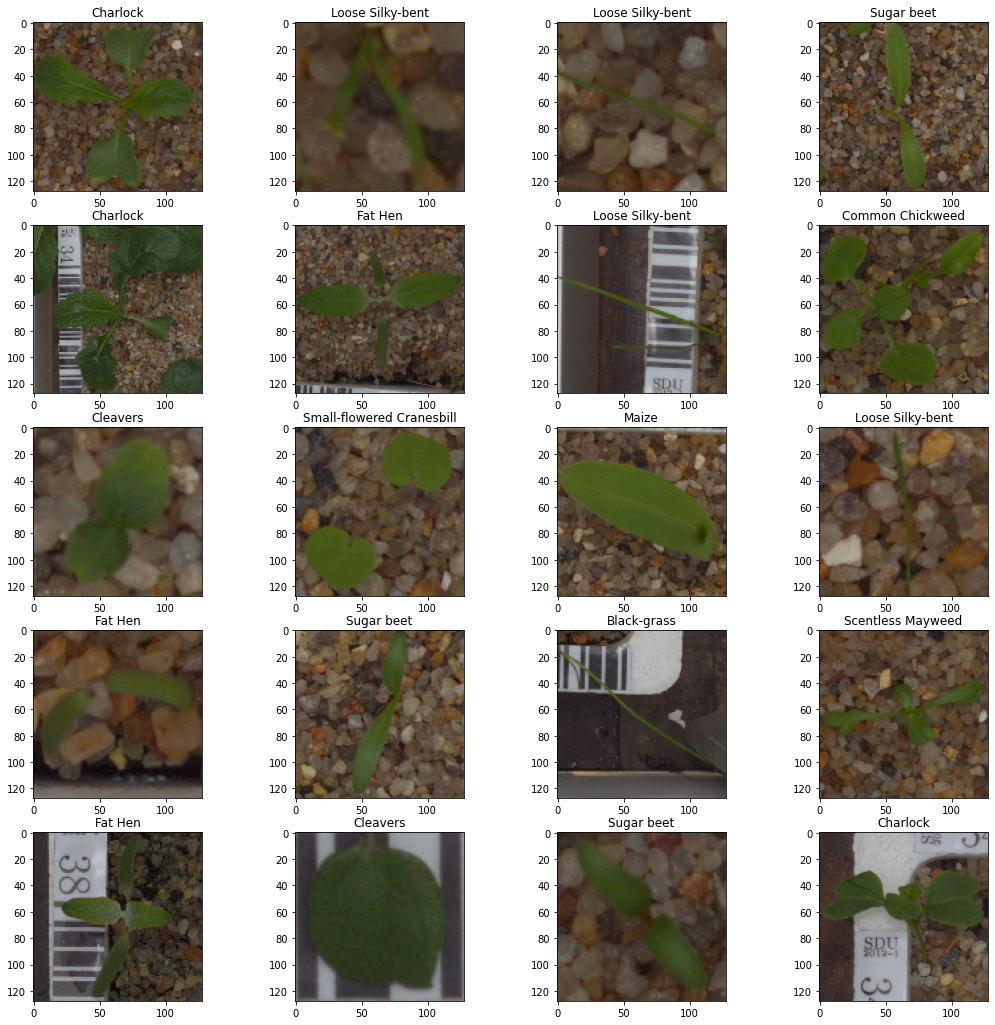

In [8]:
plot_images(images,labels)

## **EDA Analysis**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

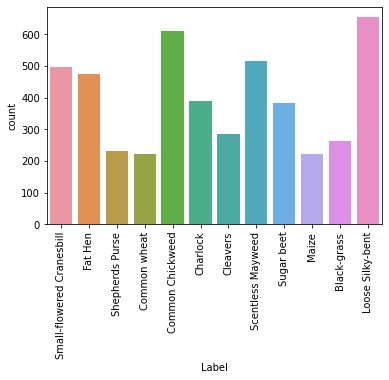

In [9]:
# Printing Proportions of Each Class in a Countplot
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')


- We can see from this plot that Loose Silky-Bent, Common Chickweed, and Scentless Mayweed are the three most present labels in this dataset. 
- Maize, Common Wheat, and Shepherds Purse are the three least present labels in this dataset. 

- This is showing overall that the classes ***ARE NOT BALANCED***. About half of the classes seem to be in the lower tier, where as half seem to have much more representation in the dataset. Loose Silky-Bent has about 650 images where Common Wheat only has about 200. 

- Among other things, we may want to decrease the size of these images from 128 pixels to 64 pixels, in order to make things easier on the computer. 



# **Data Pre-Processing**

In [10]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

- Decreasing the Size of the images.

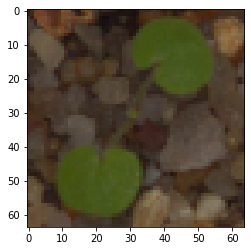

In [11]:
plt.imshow(images_decreased[5])

- Same image we printed in the beginning, although now we can see that its dimensions are 64x64

- Next we need to apply Gaussian Blur. This is done in order to remove unwanted noise from the images so that our future model performs better. I will take my decreased images and then apply Gaussian Blur on them.

In [12]:
# Applying Gaussian Blur to denoise the decreased images
images_gb=[]
for i in range(len(images_decreased)):
  # gb[i] = cv2.cvtColor(images_decreased[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images_decreased[i], ksize =(3,3),sigmaX =  0))

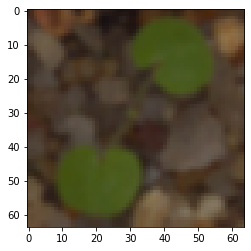

In [13]:
plt.imshow(images_gb[5])

- It seems that Gaussian Blur may not have a huge impact on some of the images, including this one here, but we can still see the background has become more blurry and the plant sticks out. We will keep the blurring for the remainder of this exercise. 

- I will be using a 90:10 split for my train/test data. This is due to the fact that there are less than 5,000 images and I want my model to be able to train on the most amount of data as possible to produce a good result.

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(images_gb),labels , test_size=0.1, random_state=14,stratify=labels)

In [15]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4275, 64, 64, 3) (4275, 1)
(475, 64, 64, 3) (475, 1)


- We have 4,275 images in the training set and 475 images in the test set. They are colored images with the dimensions of 64x64 pixels each.

- We need to normalize the data in order to make it easier on our computer. I will be dividing all pixels by 255 in order to scale the dataset.

In [16]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

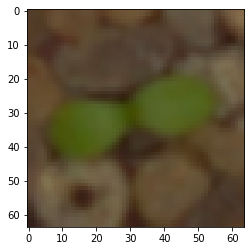

In [17]:
plt.imshow(X_train_normalized[5])

- This is what our images look like after pre-processing the data. There is a clear distinction between the background which is brown and the plant which is clearly green.

- We now need to encode our variables.

# **Encoding the Target Variables**

In [18]:
# Convert labels from names to one hot vectors.
# Labelbinarizer works similar to onehotencoder 

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_test_encoded=enc.transform(y_test)

In [19]:
y_train_encoded.shape

(4275, 12)

In [20]:
y_test_encoded.shape

(475, 12)

- Encoding was successful, as we can see the target variables have increased to 12 in both the training and test set.

# **Model Building**

In [21]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [22]:
# Fixing the seed for random number generators
import random
np.random.seed(14)
random.seed(14)
tf.random.set_seed(14)

In [23]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 100)               8

In [24]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_split=0.1,
            # shuffle=True,
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 13s - loss: 2.3166 - accuracy: 0.2004 - val_loss: 1.9447 - val_accuracy: 0.3388 - 13s/epoch - 104ms/step
Epoch 2/30
121/121 - 2s - loss: 1.8037 - accuracy: 0.3813 - val_loss: 1.5250 - val_accuracy: 0.5257 - 2s/epoch - 17ms/step
Epoch 3/30
121/121 - 2s - loss: 1.4598 - accuracy: 0.4832 - val_loss: 1.3720 - val_accuracy: 0.5397 - 2s/epoch - 16ms/step
Epoch 4/30
121/121 - 2s - loss: 1.2574 - accuracy: 0.5636 - val_loss: 1.2032 - val_accuracy: 0.5701 - 2s/epoch - 16ms/step
Epoch 5/30
121/121 - 2s - loss: 1.1658 - accuracy: 0.5994 - val_loss: 1.0835 - val_accuracy: 0.6285 - 2s/epoch - 16ms/step
Epoch 6/30
121/121 - 2s - loss: 1.0835 - accuracy: 0.6259 - val_loss: 1.0674 - val_accuracy: 0.6379 - 2s/epoch - 17ms/step
Epoch 7/30
121/121 - 2s - loss: 1.0349 - accuracy: 0.6376 - val_loss: 1.0338 - val_accuracy: 0.6659 - 2s/epoch - 16ms/step
Epoch 8/30
121/121 - 2s - loss: 1.0113 - accuracy: 0.6480 - val_loss: 0.9965 - val_accuracy: 0.6612 - 2s/epoch - 17ms/step
Epoch 9/30
12

- Plotting the results



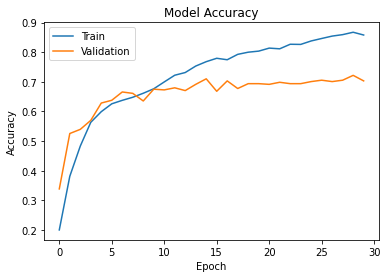

In [25]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- Clearly around .70 accuracy, our model begins to overfit. Adjustments will need to be made. We will want to check our induvidual classes before we do anything however.

In [26]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.2546 - accuracy: 0.7116 - 224ms/epoch - 15ms/step


Test accuracy is about 74%. This is a good accuracy score for this type of problem, but with the model overfitting so badly it does not make sense to use it in a testing scenario. 


In [27]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

In [28]:
y_pred

array([[1.03636912e-05, 4.41423035e-05, 2.63907186e-05, ...,
        8.43804912e-07, 2.96268894e-07, 9.95158851e-01],
       [3.48937209e-03, 3.41246678e-16, 4.35265512e-13, ...,
        4.71823068e-14, 9.01168463e-12, 2.89462660e-12],
       [1.03171043e-01, 7.42006845e-10, 4.07679380e-07, ...,
        5.34686774e-11, 2.77851603e-10, 1.01952675e-04],
       ...,
       [3.68805586e-09, 1.23001254e-15, 1.50866267e-18, ...,
        1.44564241e-04, 3.22540189e-11, 6.60752357e-06],
       [1.23039532e-13, 9.84679282e-05, 5.05097546e-07, ...,
        7.18862293e-06, 6.62682260e-06, 9.99816835e-01],
       [4.74891037e-01, 5.69539838e-09, 2.04466720e-04, ...,
        1.12863142e-10, 2.31237838e-08, 3.70422640e-04]], dtype=float32)

- We will use this y_pred to make a confusion matrix 

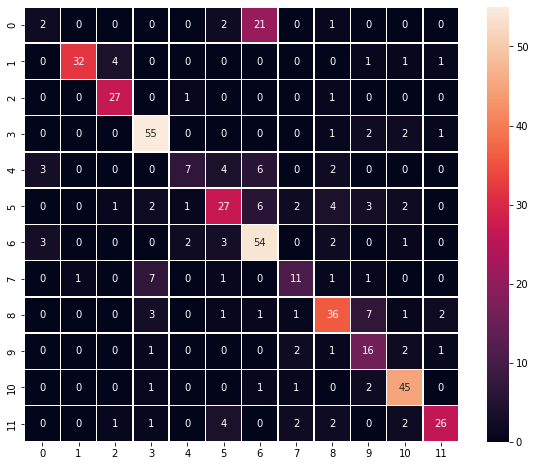

In [29]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

- There seems to be an issue with the 0, 2, 4, 7, 9 11 classes.
- Classes 1, 3, 5, 6, 8, 10 were classified well. 
- We need to make some adjustments to our model, I will attempt to use batch normalization in my ANN and Data Augmentation in order to attempt to increase validation accuracy in model 2. 

# **Model 2**

In [30]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(14)
random.seed(14)
tf.random.set_seed(14)

In [31]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20, 
                              fill_mode='nearest'
                              )
# test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [32]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

In [33]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history = model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_test_normalized,y_test_encoded),
                    verbose=1)

Epoch 1/25
66/66 [==============================] - 8s 100ms/step - loss: 1.8727 - accuracy: 0.3638 - val_loss: 2.3272 - val_accuracy: 0.1853
Epoch 2/25
66/66 [==============================] - 6s 92ms/step - loss: 1.1856 - accuracy: 0.6037 - val_loss: 2.1175 - val_accuracy: 0.3579
Epoch 3/25
66/66 [==============================] - 6s 90ms/step - loss: 1.0000 - accuracy: 0.6637 - val_loss: 1.9652 - val_accuracy: 0.3579
Epoch 4/25
66/66 [==============================] - 6s 92ms/step - loss: 0.8542 - accuracy: 0.7070 - val_loss: 1.6829 - val_accuracy: 0.6042
Epoch 5/25
66/66 [==============================] - 6s 92ms/step - loss: 0.7713 - accuracy: 0.7309 - val_loss: 1.5369 - val_accuracy: 0.6084
Epoch 6/25
66/66 [==============================] - 6s 93ms/step - loss: 0.6852 - accuracy: 0.7673 - val_loss: 1.4462 - val_accuracy: 0.5095
Epoch 7/25
66/66 [==============================] - 6s 92ms/step - loss: 0.6625 - accuracy: 0.7730 - val_loss: 0.9640 - val_accuracy: 0.7032
Epoch 8/25
6

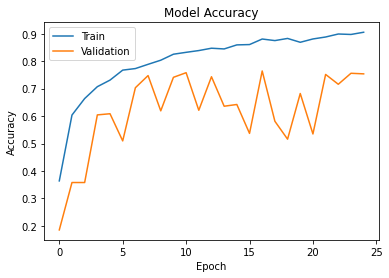

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- Clearly this model is not good whatsoever. Validation accuracy is all over the place, and the model is overfitting tremendously. 

In [35]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.8026 - accuracy: 0.7537 - 119ms/epoch - 8ms/step


- Test accuracy for this model is right around 74%, although that does not mean much when the model is clearly overfitting badly.

In [36]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

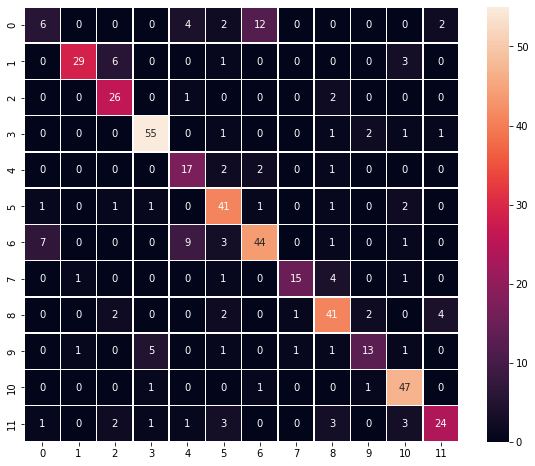

In [37]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

- My first model seemed to do better on almost all fronts. I am going to try transfer learning next, using weights from VGG16. Hopefully this will increase the strength of my model. 

# **Model 3**

In [38]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.


In [39]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [40]:
from keras.backend import batch_normalization
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.20))
new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.20))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.20))
new_model.add(Dense(32, activation='relu'))
new_model.add(BatchNormalization())
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.20))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Epochs
epochs = 50
# Batch size
batch_size = 64

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=14,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_test_normalized,y_test_encoded),
                    verbose=1,
                    callbacks=[es, mc])


Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 2.4976 - accuracy: 0.1147
Epoch 1: val_accuracy improved from -inf to 0.18105, saving model to best_model.h5
66/66 [==============================] - 14s 165ms/step - loss: 2.4976 - accuracy: 0.1147 - val_loss: 2.3798 - val_accuracy: 0.1811
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 2.3301 - accuracy: 0.1916
Epoch 2: val_accuracy improved from 0.18105 to 0.25263, saving model to best_model.h5
66/66 [==============================] - 8s 123ms/step - loss: 2.3301 - accuracy: 0.1916 - val_loss: 2.1853 - val_accuracy: 0.2526
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 2.1465 - accuracy: 0.2444
Epoch 3: val_accuracy did not improve from 0.25263
66/66 [==============================] - 9s 129ms/step - loss: 2.1465 - accuracy: 0.2444 - val_loss: 2.0731 - val_accuracy: 0.2484
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 2.0460 - accuracy: 0.2565
Epoch 4: v

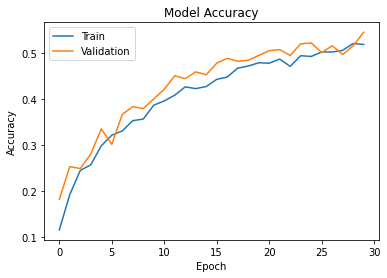

In [42]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- This model is fitting very well. The only problem I see is that it does not have a very high accuracy. I would like to make that higher if possible. The model needs to be able to perform at better than roughly 50%.

In [43]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 1.4202 - accuracy: 0.5453 - 687ms/epoch - 46ms/step


In [44]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

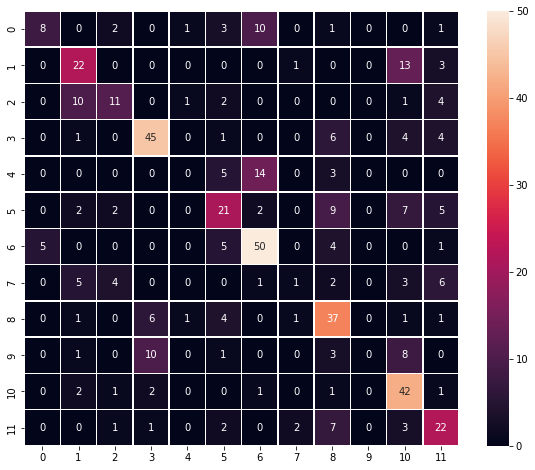

In [45]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

- 2 classes seem to have not been predicted at all. Transfer learning seems to help not overfit the problem very well, there is a clear link between this data set and the images of plants in the imagenet dataset. However, although there is no overfitting, there is an issue with accuracy in general. 

- I am choosing to improve the first model I created and use that as a final model for my predictions. I need accuracy to be higher if I expect to predict anything with certainty. 

# **Final Model**

In [46]:
# Fixing the seed for random number generators
import random
np.random.seed(14)
random.seed(14)
tf.random.set_seed(14)

In [47]:
# Intializing a sequential model
model4 = Sequential()
model4.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
model4.add(MaxPooling2D((2, 2), padding = 'same'))
model4.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model4.add(MaxPooling2D((2, 2), padding = 'same'))
model4.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model4.add(MaxPooling2D((2, 2), padding = 'same'))
model4.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model4.add(MaxPooling2D((2, 2), padding = 'same'))

model4.add(Flatten())

model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(16, activation='relu'))
model4.add(Dropout(0.1))

model4.add(Dense(12, activation='softmax'))

opt=Adam()

model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)        

In [48]:
history_final = model4.fit(
            X_train_normalized, y_train_encoded,
            epochs=35,
            validation_split=0.1,
            # shuffle=True,
            batch_size=64,
            verbose=2
)

Epoch 1/35
61/61 - 3s - loss: 2.4571 - accuracy: 0.1279 - val_loss: 2.4277 - val_accuracy: 0.1449 - 3s/epoch - 51ms/step
Epoch 2/35
61/61 - 2s - loss: 2.4354 - accuracy: 0.1344 - val_loss: 2.4249 - val_accuracy: 0.1449 - 2s/epoch - 27ms/step
Epoch 3/35
61/61 - 2s - loss: 2.4304 - accuracy: 0.1370 - val_loss: 2.4081 - val_accuracy: 0.1449 - 2s/epoch - 27ms/step
Epoch 4/35
61/61 - 2s - loss: 2.4230 - accuracy: 0.1347 - val_loss: 2.4144 - val_accuracy: 0.1449 - 2s/epoch - 27ms/step
Epoch 5/35
61/61 - 2s - loss: 2.4214 - accuracy: 0.1401 - val_loss: 2.3945 - val_accuracy: 0.1449 - 2s/epoch - 28ms/step
Epoch 6/35
61/61 - 2s - loss: 2.3811 - accuracy: 0.1679 - val_loss: 2.1591 - val_accuracy: 0.2593 - 2s/epoch - 27ms/step
Epoch 7/35
61/61 - 2s - loss: 2.1263 - accuracy: 0.2501 - val_loss: 1.9054 - val_accuracy: 0.3061 - 2s/epoch - 28ms/step
Epoch 8/35
61/61 - 2s - loss: 1.8732 - accuracy: 0.3228 - val_loss: 1.5934 - val_accuracy: 0.4112 - 2s/epoch - 27ms/step
Epoch 9/35
61/61 - 2s - loss: 1.

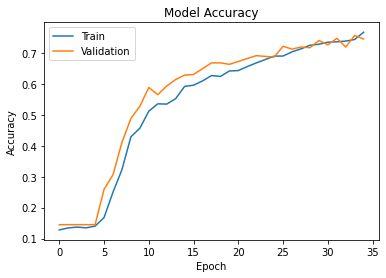

In [49]:
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- The model seems to fit very well, especially towards the end. It was important to me to at least create a model that did not over fit. 

In [50]:
accuracy = model4.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.7662 - accuracy: 0.7726 - 221ms/epoch - 15ms/step


- This model has a test accuracy of almost 77%, making it my best accuracy of all four models I created.

In [51]:
# Here we would get the output as probablities for each category
y_pred=model4.predict(X_test_normalized)
y_pred

array([[5.7872396e-05, 2.0967280e-04, 1.7622222e-04, ..., 3.7444948e-05,
        7.4010884e-04, 9.4666064e-01],
       [1.5494791e-01, 5.2995487e-17, 6.2144012e-11, ..., 6.0857412e-13,
        6.4271823e-14, 2.3512564e-10],
       [1.3835211e-01, 8.6373757e-06, 9.2653912e-03, ..., 6.7253299e-05,
        6.5000850e-06, 2.1434065e-04],
       ...,
       [5.8007303e-14, 1.0994579e-15, 6.6955361e-18, ..., 1.9320594e-04,
        3.4611197e-10, 1.9738846e-07],
       [5.4395932e-06, 4.1449210e-05, 1.4218806e-05, ..., 1.8442006e-06,
        4.2510123e-04, 9.9000227e-01],
       [1.3551080e-01, 5.1728246e-05, 4.7597367e-02, ..., 1.8090420e-04,
        2.0767618e-05, 8.6585694e-04]], dtype=float32)

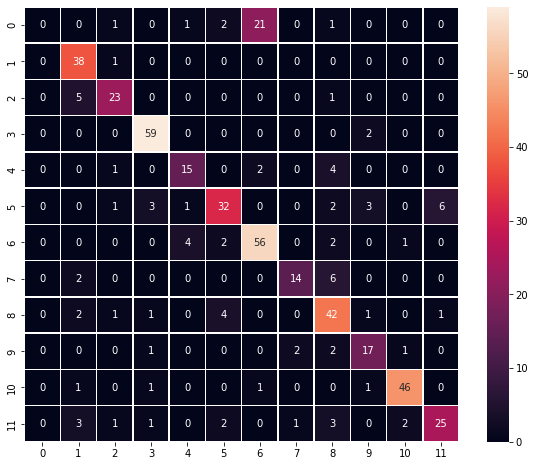

In [52]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

- The model still has some difficulty predicting the 0 class, as if there were no 0 class images in the test set, however, this is not the case. other than that, this confusing matrix is much more balanced, and represents far greater a model than any of the previous ones I have made. 

- Class 6 has a clear hiccup - it seems that my model thinks that most images belonging to class 0 are actually class 6. Seeing that class 6 has a large representation in the test set, most likely not enough data augmentation/class balancing was done by me to fix this issue.

# **Visualizing The Prediction**

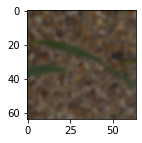

Predicted Label ['Common wheat']
True Label Common wheat


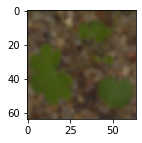

Predicted Label ['Scentless Mayweed']
True Label Loose Silky-bent


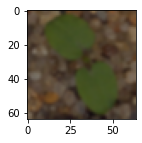

Predicted Label ['Common Chickweed']
True Label Common Chickweed


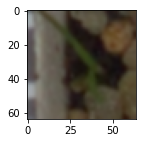

Predicted Label ['Loose Silky-bent']
True Label Loose Silky-bent


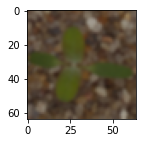

Predicted Label ['Common wheat']
True Label Common wheat


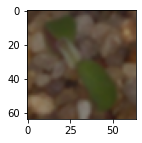

Predicted Label ['Common wheat']
True Label Common wheat


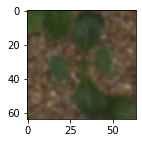

Predicted Label ['Common wheat']
True Label Common wheat


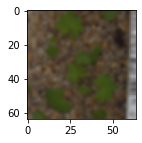

Predicted Label ['Common wheat']
True Label Common wheat


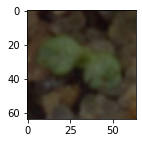

Predicted Label ['Common wheat']
True Label Common wheat


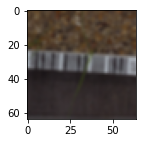

Predicted Label ['Common wheat']
True Label Common wheat


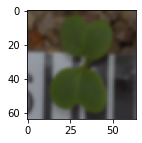

Predicted Label ['Common wheat']
True Label Common wheat


In [53]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model4.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[11])
plt.show()
print('Predicted Label', enc.inverse_transform(model4.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[28],)
plt.show()
print('Predicted Label', enc.inverse_transform(model4.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model4.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])    

plt.figure(figsize=(2,2))
plt.imshow(X_test[44])
plt.show()
print('Predicted Label', enc.inverse_transform(model4.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[55])
plt.show()
print('Predicted Label', enc.inverse_transform(model4.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[66])
plt.show()
print('Predicted Label', enc.inverse_transform(model4.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[77])
plt.show()
print('Predicted Label', enc.inverse_transform(model4.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[88])
plt.show()
print('Predicted Label', enc.inverse_transform(model4.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[99])
plt.show()
print('Predicted Label', enc.inverse_transform(model4.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[114])
plt.show()
print('Predicted Label', enc.inverse_transform(model4.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

- As we can see, my model has predicted 10/11 test images correctly at an accuracy of 77%. I believe this is a very good result seeing my final model was not using much augmententation at all, just normalized and blurred data. 

# **Conclusion**

- In this exercise, the only metric I focused on was accuracy. This is due to the fact that I am trying to build a model which can best predict images of plants. The model needs to accurately be able to do that on a consistant basis. Below, I will show the accuracy levels of all the models I created.  

In [55]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model', 'Final Model'],'Train Accuracy':['86%','91%','52%', '76%'],'Test Accuracy':['71%','75%','54%', '77%']})

,Models,Train Accuracy,Test Accuracy
0,Base CNN Model,86%,71%
1,CNN Model with Data Augmentation,91%,75%
2,Transfer Learning Model,52%,54%
3,Final Model,76%,77%


- As we can see, my final model was the most consistant. It had not only the best testing accuracy, also fit the best. This would ultimately mean that if added images to my testing set, my model should be able to consistantly able to identify them.

- My final model, while being pretty good, still has some issues of its own. These are shown by the confusion matrix. It misclassified an entire class of images. Improvements I list below could solve this.  

- I was not expecting to make a perfect model. Multiple things could be done to improve all of the models that I created.

# **Improvements**

- Data Augmentation can be done in so many different ways, it is clearly the number one improvement I would make to my models. I believe a reason for doing this is to balance the classes. The classes were unbalanced from the start, and I did not do anything to improve that, mainly because I wanted to see what shrinking the images and adding Gaussian Blur to them did instead. 

- Anothing thing that is very clear is how successful Transfer Learning could be for this problem. It would just take a lot more fine tuning on the ANN after freezing the layers from the previous model. For example, ImageNet has plenty of plants in its data base, there is no way that we can't use a model based off ImageNet for this. However, maybe the one I used is simply not the right one? Trying different Transfer Learning architectures could help build a good model I believe. 

- We used Gaussian Blurring in this problem. I think that in some ways this hurt the model. Some of the images of the plants had backgrounds that were very distracting and I think it would be interesting to see how the models perform with data that is not blurred.

- I decided to shrink my images to (64, 64, 3) size, I wonder how the models would perform if I had left them at (128, 128, 3) instead. 

- As always, a different number of filters and different filter sizes can always be changed in order to see a different result. If I were to do this again, I would definitely experiment on this end. 
